<a href="https://colab.research.google.com/github/mohamed-zayton/Face-Recognition/blob/non_face/pca_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import PIL
from PIL import Image
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

1. Download the Dataset and Understand the Format

In [38]:
#Downloaded in the project directory
#Image formate pgm 'grey scale img'

2. Generate the Data Matrix and the Label vector

In [96]:
i = 0
s = 1
x = 1
d = [0] * 400
y = [0] * 400

In [97]:
while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  y[i] = s
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

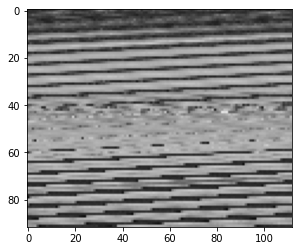

In [30]:
plt.imshow(np.reshape(d[0], (92, 112)), cmap='gray', vmin=0, vmax=255)
plt.show()

3. Split the Dataset into Training and Test sets

In [83]:
training_data = [0] * 200
testing_data = [0] * 200
training_labels = [0] * 200
testing_labels = [0] * 200
curr_index = 0

In [ ]:
for i in range(1, 400, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

4. Classification using PCA

Declaring variables

In [135]:
alpha = [0.8, 0.85, 0.9, 0.95]
n = len(testing_data[0])

Calculating centered data, covariance matrix, eigen values, and eigen vectors

In [34]:
def calculate_reduced_basis(data_to_reduce, alpha_val):
    
    attributes_means = np.mean(data_to_reduce, axis=0)
    Z = np.subtract(data_to_reduce, attributes_means.T)
    cov_matrix = np.cov(Z.T)
    eval, evec = np.linalg.eigh(cov_matrix)
    
    idx = eval.argsort()[::-1]
    eva = eval[idx]
    eve = evec[:,idx]
    eval_sum = np.sum(eval)
    
    reduced_basis = []
    for curr_alpha in alpha:
        dimensionality = 0
        curr_eval_sum = 0
        for curr_eval in eva:
            dimensionality += 1
            curr_eval_sum += curr_eval
            if curr_eval_sum / eval_sum >= curr_alpha:
                break
    
        reduced_basis.append(eve[:, :dimensionality])
        
    return reduced_basis

6. Classifier Tuning

Declaring the models

In [136]:
model_1_pca = KNeighborsClassifier(n_neighbors=1)
model_3_pca = KNeighborsClassifier(n_neighbors=3)
model_5_pca = KNeighborsClassifier(n_neighbors=5)
model_7_pca = KNeighborsClassifier(n_neighbors=7)
models = [model_1_pca, model_3_pca, model_5_pca, model_7_pca]

Classifying the images

In [45]:
def classify_images(f_alpha, f_training_reduced_basis, f_training_data, f_training_labels, f_testing_data, f_testing_labels):
    for i in range(len(f_alpha)):
        reduced_dim_data = np.dot(f_training_data, f_training_reduced_basis[i])
        reduced_dim_test = np.dot(f_testing_data, f_training_reduced_basis[i])
        
        model_1_pca.fit(reduced_dim_data, f_training_labels)
        model_3_pca.fit(reduced_dim_data, f_training_labels)
        model_5_pca.fit(reduced_dim_data, f_training_labels)
        model_7_pca.fit(reduced_dim_data, f_training_labels)
        
        print("When alpha = " + str(f_alpha[i]))
        for k in range(1, 8, 2):
            pred_model = models[int(k / 2)].predict(reduced_dim_test)
            print("K-NN classifier PCA " + str(k) + "  Accuracy is: " + str(accuracy_score(f_testing_labels, pred_model)))
        
        print("**********************")

In [46]:
training_reduced_basis = calculate_reduced_basis(training_data, alpha)

In [47]:
classify_images(alpha, training_reduced_basis, training_data, training_labels, testing_data, testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.85
K-NN classifier PCA 7  Accuracy is: 0.805
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.775
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.835
K-NN classifier PCA 7  Accuracy is: 0.77
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.74
**********************


5. Classification Using LDA

In [35]:
def center_function(d):
    m = np.mean(d, axis=0)
    return np.subtract(d, m)

In [39]:
def lda(data, l, dom, n_class, features):
  # Calculate the mean of feature for every class
  # Mean matrix is 10304x1 dim
  cdata = []
  for i in range(0, len(data), l):
    cdata.append(data[i:i+l])
  mean_c = []
  for i in range(n_class):
    mean_c.append(np.mean(cdata[i], axis=0))
  if n_class != 2:
    tmean = np.mean(data, axis=0) 

  # Calculate between-class scatter matrix
  # B matrix is 10304 x 10304
  bmat = np.zeros((features, features))
  if n_class == 2:
    sub = np.subtract(mean_c[0], mean_c[1])
    bmat = np.dot(sub, sub.T)
  else:
    tm = tmean[:, np.newaxis]
    for i in range(n_class):
      mc = mean_c[i][:, np.newaxis]
      sub = np.subtract(mc, tm)
      bmat += np.multiply(l, np.dot(sub, sub.T))

  # Center class matrix 
  # Zi matrix is 5 x 10304
  zmat = []
  for d in cdata:
    zmat.append(center_function(d))
  
  # Class scatter matrix 
  # S matrix is 10304 x 10304
  s_tot = np.zeros((features, features))
  for zi in zmat:
    s_tot += np.dot(zi.T, zi)
 
  # Compute dominant eigenvector
  eval, evec = np.linalg.eigh(np.dot(np.linalg.inv(s_tot), bmat))

  # Return the 39 dominant eigenvectors and the mean
  idx = eval.argsort()[::-1]
  eva = eval[idx]
  eve = evec[:,idx]
  dom_arr = eve[:,:dom]
  
  return dom_arr.T

In [37]:
pj_mat = lda(training_data, 5, 39, 40, 10304)

In [40]:
pj_mat.shape

(39, 10304)

In [41]:
np.asarray(d).shape

(400, 10304)

In [42]:
new_train = np.dot(training_data, pj_mat.T)
new_train.shape

(200, 39)

In [43]:
new_test = np.dot(testing_data, pj_mat.T)
new_test.shape

(200, 39)

6. Classifier Tuning

In [48]:
model_1_lda = KNeighborsClassifier(n_neighbors=1)
model_3_lda = KNeighborsClassifier(n_neighbors=3)
model_5_lda = KNeighborsClassifier(n_neighbors=5)
model_7_lda = KNeighborsClassifier(n_neighbors=7)

In [49]:
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)

KNeighborsClassifier(n_neighbors=7)

In [50]:
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
pred_model_1_lda

array([ 1,  1,  1,  1, 16,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5, 40,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,  8, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 37, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       25, 15, 35, 25,  5, 36, 36, 36, 36, 17, 37, 37, 37, 37, 37, 38, 38,
       38, 38, 38, 39, 39, 39, 39, 39, 40,  5, 40, 40, 40])

In [51]:
testing_labels

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38,
       38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40])

In [52]:
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.95
0.865
0.81
0.77


Compare PCA & LDA

In [53]:
print("K-NN classifier 1 LDA   Accuracy is: " + str(acc_1_lda))
print("K-NN classifier 3 LDA   Accuracy is: " + str(acc_3_lda))
print("K-NN classifier 5 LDA   Accuracy is: " + str(acc_5_lda))
print("K-NN classifier 7 LDA   Accuracy is: " + str(acc_7_lda))
for i in range(len(alpha)):
    reduced_dim_data = np.dot(training_data, training_reduced_basis[i])
    reduced_dim_test = np.dot(testing_data, training_reduced_basis[i])
    
    model_1_pca.fit(reduced_dim_data, training_labels)
    model_3_pca.fit(reduced_dim_data, training_labels)
    model_5_pca.fit(reduced_dim_data, training_labels)
    model_7_pca.fit(reduced_dim_data, training_labels)
    
    print("When alpha = " + str(alpha[i]))
    for k in range(1, 8, 2):
        pred_model = models[int(k / 2)].predict(reduced_dim_test)
        print("K-NN classifier PCA " + str(k) + "  Accuracy is: " + str(accuracy_score(testing_labels, pred_model)))
        
    print("**********************")

K-NN classifier 1 LDA   Accuracy is: 0.95
K-NN classifier 3 LDA   Accuracy is: 0.865
K-NN classifier 5 LDA   Accuracy is: 0.81
K-NN classifier 7 LDA   Accuracy is: 0.77
When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.85
K-NN classifier PCA 7  Accuracy is: 0.805
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.775
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.835
K-NN classifier PCA 7  Accuracy is: 0.77
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.74
**********************


7. Compare vs Non-Face Images

In [137]:
i = 0
x = 1
s = 1
d = [0] * 800
y = [0] * 800

In [138]:
while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

while i < 800:
  image = PIL.Image.open("dataset/a/" + str(x) + ".jpg")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  image_array.resize((10304,))
  d[i] = image_array
  y[i] = 1
  i = i + 1
  x = x + 1

training_data = [0] * 400
testing_data = [0] * 400
training_labels = [0] * 400
testing_labels = [0] * 400
curr_index = 0

for i in range(1, 800, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [139]:
training_reduced_basis = calculate_reduced_basis(training_data, alpha)

In [140]:
classify_images(alpha, training_reduced_basis, training_data, training_labels, testing_data, testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 1.0
K-NN classifier PCA 3  Accuracy is: 0.9975
K-NN classifier PCA 5  Accuracy is: 0.9975
K-NN classifier PCA 7  Accuracy is: 1.0
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 1.0
K-NN classifier PCA 3  Accuracy is: 0.9975
K-NN classifier PCA 5  Accuracy is: 0.9975
K-NN classifier PCA 7  Accuracy is: 0.9975
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 1.0
K-NN classifier PCA 3  Accuracy is: 1.0
K-NN classifier PCA 5  Accuracy is: 1.0
K-NN classifier PCA 7  Accuracy is: 1.0
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 1.0
K-NN classifier PCA 3  Accuracy is: 1.0
K-NN classifier PCA 5  Accuracy is: 1.0
K-NN classifier PCA 7  Accuracy is: 1.0
**********************


In [141]:
pj_mat = lda(training_data, 5, 1, 2, 10304)

In [142]:
pj_mat.shape

(1, 10304)

In [143]:
np.asarray(d).shape

(800, 10304)

In [144]:
new_train = np.dot(training_data, pj_mat.T)
new_train.shape

(400, 1)

In [145]:
new_test = np.dot(testing_data, pj_mat.T)
new_test.shape

(400, 1)

In [146]:
model_1_lda = KNeighborsClassifier(n_neighbors=1)
model_3_lda = KNeighborsClassifier(n_neighbors=3)
model_5_lda = KNeighborsClassifier(n_neighbors=5)
model_7_lda = KNeighborsClassifier(n_neighbors=7)

In [147]:
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)

KNeighborsClassifier(n_neighbors=7)

In [148]:
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
pred_model_1_lda

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,

In [149]:
testing_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [150]:
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.5225
0.56
0.545
0.5275


8. Bonus

In [54]:
trainingset_ratio = 0.7

b_training_data = [0] * int(len(d) * trainingset_ratio) 
b_testing_data = [0] * (len(d) - len(b_training_data))
b_training_labels = [0] * len(b_training_data)
b_testing_labels = [0] * len(b_testing_data)
curr_index = 0
for i in range(int(len(d) / 10)):
    for j in range(int(10 * trainingset_ratio)):
        b_training_data[i * int(10 * trainingset_ratio) + j] = d[i * 10 + j]
        b_training_labels[i * int(10 * trainingset_ratio) + j] = y[i * 10 + j]
        
    for j in range(int(10 * (1 - trainingset_ratio))):
        b_testing_data[i * int(10 * (1 - trainingset_ratio)) + j] = d[i * 10 + int(10 * trainingset_ratio) + j]
        b_testing_labels[i * int(10 * (1 - trainingset_ratio)) + j] = y[i * 10 + int(10 * trainingset_ratio) + j]


b_training_data = np.array(b_training_data)
b_training_labels = np.array(b_training_labels)
b_testing_data = np.array(b_testing_data)
b_testing_labels = np.array(b_testing_labels)

In [55]:
training_reduced_basis = calculate_reduced_basis(b_testing_data, alpha)

In [56]:
classify_images(alpha, training_reduced_basis, b_training_data, b_training_labels, b_testing_data, b_testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.925
K-NN classifier PCA 5  Accuracy is: 0.8833333333333333
K-NN classifier PCA 7  Accuracy is: 0.8416666666666667
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9
K-NN classifier PCA 7  Accuracy is: 0.8833333333333333
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666667
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.9666666666666667
K-NN classifier PCA 3  Accuracy is: 0.95
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666667
**********************


In [57]:
b_pj_mat = lda(b_training_data, 5, 39, 40, 10304)

In [58]:
b_new_train = np.dot(b_training_data, b_pj_mat.T)
b_new_test = np.dot(b_testing_data, b_pj_mat.T)

In [59]:
model_1_lda.fit(b_new_train, b_training_labels)
model_3_lda.fit(b_new_train, b_training_labels)
model_5_lda.fit(b_new_train, b_training_labels)
model_7_lda.fit(b_new_train, b_training_labels)

KNeighborsClassifier(n_neighbors=7)

In [60]:
b_pred_model_1_lda = model_1_lda.predict(b_new_test)
b_pred_model_3_lda = model_3_lda.predict(b_new_test)
b_pred_model_5_lda = model_5_lda.predict(b_new_test)
b_pred_model_7_lda = model_7_lda.predict(b_new_test)

In [61]:
b_acc_1_lda = accuracy_score(b_testing_labels, b_pred_model_1_lda)
b_acc_3_lda = accuracy_score(b_testing_labels, b_pred_model_3_lda)
b_acc_5_lda = accuracy_score(b_testing_labels, b_pred_model_5_lda)
b_acc_7_lda = accuracy_score(b_testing_labels, b_pred_model_7_lda)
print(b_acc_1_lda)
print(b_acc_3_lda)
print(b_acc_5_lda)
print(b_acc_7_lda)

0.9166666666666666
0.8333333333333334
0.6833333333333333
0.65


Compare PCA & LDA

In [62]:
print("K-NN classifier 1 LDA   Accuracy is: " + str(b_acc_1_lda))
print("K-NN classifier 3 LDA   Accuracy is: " + str(b_acc_3_lda))
print("K-NN classifier 5 LDA   Accuracy is: " + str(b_acc_5_lda))
print("K-NN classifier 7 LDA   Accuracy is: " + str(b_acc_7_lda))
classify_images(alpha, training_reduced_basis, b_training_data, b_training_labels, b_testing_data, b_testing_labels)

K-NN classifier 1 LDA   Accuracy is: 0.9166666666666666
K-NN classifier 3 LDA   Accuracy is: 0.8333333333333334
K-NN classifier 5 LDA   Accuracy is: 0.6833333333333333
K-NN classifier 7 LDA   Accuracy is: 0.65
When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.925
K-NN classifier PCA 5  Accuracy is: 0.8833333333333333
K-NN classifier PCA 7  Accuracy is: 0.8416666666666667
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9
K-NN classifier PCA 7  Accuracy is: 0.8833333333333333
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666667
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy i